## Connecting to Drive

We will connect the colab file to drive in order to access the dataset with predefined labeled images.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Dataset Preparation

We will reorganize the images in the dataset based on the predefined label mappings in the dataset. The images are copied from the original dataset and stored in the refined dataset for further usage. This preparation process helps for streamlining and better dataset management.


In [ ]:
import os
import shutil

# base path
dataset_path = '/content/drive/My Drive/Capstone'

# refined dataset
refined_dataset_base_path = '/content/drive/My Drive/Capstone'
refined_dataset_path = os.path.join(refined_dataset_base_path, 'refined_dataset')

os.makedirs(refined_dataset_path, exist_ok=True)

label_mappings = {
    'basal cell carcinoma': 'basal cell carcinoma',
    'actinic keratosis': 'actinic keratosis',
    'Acne': 'acne',
    'milia': 'milia',
    'freckle' :'freckle'
}

# iterate over the directories in the base dataset path
for dir_name in os.listdir(dataset_path):
    if dir_name in label_mappings:
        full_dir_path = os.path.join(dataset_path, dir_name)
        if os.path.isdir(full_dir_path):
            for filename in os.listdir(full_dir_path):
                source_path = os.path.join(full_dir_path, filename)
                destination_path = os.path.join(refined_dataset_path, label_mappings[dir_name], filename)
                os.makedirs(os.path.dirname(destination_path), exist_ok=True)
                if source_path != destination_path:
                    shutil.copy(source_path, destination_path)

print("Dataset reorganization complete.")


Dataset reorganization complete.


## Dataset Image Limiting

We will now create a dataset called the refined datset which will contain limited number of images for each respective class. We wwill also specify a backup path. The images are selected randomly to store in the backup data so that we can maange the data better.

In [ ]:
import os
import shutil
import random

dataset_path = '/content/drive/My Drive/Capstone/refined_dataset'

# max number of images per class
max_images_per_class = 300

# backup files
backup_path = '/content/drive/My Drive/Capstone/superbackup'

os.makedirs(backup_path, exist_ok=True)

# iterate over the classes
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)

    class_backup_dir = os.path.join(backup_path, class_name)
    os.makedirs(class_backup_dir, exist_ok=True)

    if os.path.isdir(class_dir):
        files = os.listdir(class_dir)
        # if the number of files exceeds the maximum, randomly select files to keep and move the rest to backup
        if len(files) > max_images_per_class:
            keep_files = set(random.sample(files, max_images_per_class))
            move_files = [f for f in files if f not in keep_files]
            for file_name in move_files:
                src_file = os.path.join(class_dir, file_name)
                dst_file = os.path.join(class_backup_dir, file_name)
                shutil.move(src_file, dst_file)

print("Dataset limiting complete. Excess files moved to backup.")


Dataset limiting complete. Excess files moved to backup.


## CNN Model using Transfer Learning

We start by using the refined dataset to define data generators, to get the images set for training, with one for augmented training data and other one for just the validation data. We further use InceptionV3, a pre-trained CNN model, with teh ImageNet dataset. For the pre-trained model we import it withput the fully connected layers, we add our own flattened layer and two dense layers as well. The idea is to use transfer learning to benefit of pre-trained model weights.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
import numpy as np

dataset_path = '/content/drive/My Drive/Capstone/refined_dataset'

# training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# validation data generator just rescaling
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# training data generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    subset='training'
)

# validation data generator
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    subset='validation'
)

pretrained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights="imagenet")

for layer in pretrained_model.layers:
        layer.trainable=False

model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))



Found 912 images belonging to 5 classes.
Found 227 images belonging to 5 classes.


## Hyperparameter Tuning using Keras Tuner

We use the keras tuner library here to get the best and most optimal hyperparameters combination for the model. It maximizes teh valdation accuracy We have also incorporated early stopping callback in order to prevent the issue of overfitting on our model.


In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
# we used GPT4 for this function to assist us with using keras tuner
# it takes too long to run but the optimal values were 512 units for first dense layer and a learning rate of 0.0001
def build_model(hp):
    model = Sequential()
    pretrained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights="imagenet")
    for layer in pretrained_model.layers:
        layer.trainable = False
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=256, max_value=1024, step=256),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                    hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=50,
             callbacks=[stop_early])

# getting the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.fit(train_generator, validation_data=validation_generator, epochs=50)


Trial 9 Complete [00h 00m 50s]
val_accuracy: 0.691629946231842

Best val_accuracy So Far: 0.7444933652877808
Total elapsed time: 00h 12m 07s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
768               |256               |units
0.1               |0.2               |dropout
0.001             |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



## Model Training

We start with building a model architecture with the InceptionV3 model and the other layers like the flattened layer, dense layers with relu and softmax activation to do multi-class classification. We use categorical cross-entropy loss and adam optimizer to compile the model and train it further. Lastly, we prepare the test data and make predictions with the training model.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam


# load pre-trained InceptionV3 model
pretrained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights="imagenet")
for layer in pretrained_model.layers:
    layer.trainable = False

model = Sequential([
    pretrained_model,
    Flatten(),
    Dense(512, activation='relu'),  #optimal number of units
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=11)

test_dataset_path = '/content/drive/My Drive/Capstone/testing/test_set'

test_datagen = ImageDataGenerator(rescale=1./255)

# test data generator
test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle=False
)



Epoch 1/11
18/46 [==========>...................] - ETA: 5:41 - loss: 2.4530 - accuracy: 0.3693

In [ ]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

In [ ]:
model.save('/content/drive/My Drive/Capstone/skinwisepro.h5')

NameError: name 'model' is not defined

In [ ]:
pretrained_model

## Model Performance with Test Set

We now test the model performance using the test set that is generated using image generator.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import os

model = load_model('/content/drive/My Drive/Capstone/skinwisepro.h5')

test_dir = '/content/drive/My Drive/Capstone/testing'


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode=None,
    shuffle=True
)

index_to_class_name = {
    0: 'acne',
    1: 'actinic keratosis',
    2: 'basal cell carcinoma',
    3: 'freckle',
    4: 'milia'
}


predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
filenames = test_generator.filenames

for i, (prediction, filename) in enumerate(zip(predictions, filenames)):
    predicted_class = predicted_classes[i]
    predicted_class_name = index_to_class_name[predicted_class]
    probability = np.max(prediction)
    print(f"Image: {filename} - Predicted class: {predicted_class_name}, Probability: {probability:.4f}")


Found 537 images belonging to 1 classes.
27/27 [==============================] - 8s 253ms/step
Image: test_set/IMG_1301.png - Predicted class: actinic keratosis, Probability: 0.4872
Image: test_set/IMG_1453.png - Predicted class: acne, Probability: 0.8674
Image: test_set/IMG_2461.png - Predicted class: actinic keratosis, Probability: 0.5119
Image: test_set/IMG_2596.png - Predicted class: acne, Probability: 0.6125
Image: test_set/IMG_2751.png - Predicted class: freckle, Probability: 0.4070
Image: test_set/IMG_3014.png - Predicted class: acne, Probability: 0.3415
Image: test_set/IMG_3476.png - Predicted class: basal cell carcinoma, Probability: 0.8800
Image: test_set/IMG_3879.png - Predicted class: acne, Probability: 0.6838
Image: test_set/IMG_3916.png - Predicted class: milia, Probability: 0.9989
Image: test_set/IMG_4032.png - Predicted class: actinic keratosis, Probability: 0.5489
Image: test_set/IMG_4097.png - Predicted class: acne, Probability: 0.4472
Image: test_set/IMG_4179.png - 

## Labeling Test Images

We label the test images for creating the confusion matrix to evaluate the CNN model.


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

test_images_path = '/content/drive/My Drive/Capstone/testing/test_set'

# label based on filename
def get_label_from_filename(filename):
    if 'ak' in filename.lower():
        return 'actinic keratosis'
    elif 'actinic' in filename.lower():
        return 'actinic keratosis'
    elif 'basal' in filename.lower():
        return 'basal cell carcinoma'
    elif 'isic' in filename.lower():
        return 'basal cell carcinoma'
    elif 'img' in filename.lower():
        return 'acne'
    elif 'levle' in filename.lower():
        return 'acne'
    elif 'milia' in filename.lower():
        return 'milia'
    elif 'freckle' in filename.lower():
        return 'freckle'
    else:
        return 'unknown'

def load_images_and_labels(image_dir):
    filenames = os.listdir(image_dir)
    images = []
    labels = []

    for filename in filenames:
        label = get_label_from_filename(filename)
        image_path = os.path.join(image_dir, filename)
        image = load_img(image_path, target_size=(150, 150))
        image_array = img_to_array(image)
        images.append(image_array)
        labels.append(label)

    return np.array(images), np.array(labels)

# encoding to integers
images, labels = load_images_and_labels(test_images_path)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

## Confusion Matrix Generation

We create a confusion matrix here using the predictions made by the model and also the labeled test images. The confusion matrix will help us to decide if there has been misclassification made by the model and for which of the specific labels.

17/17 [==============================] - 13s 139ms/step


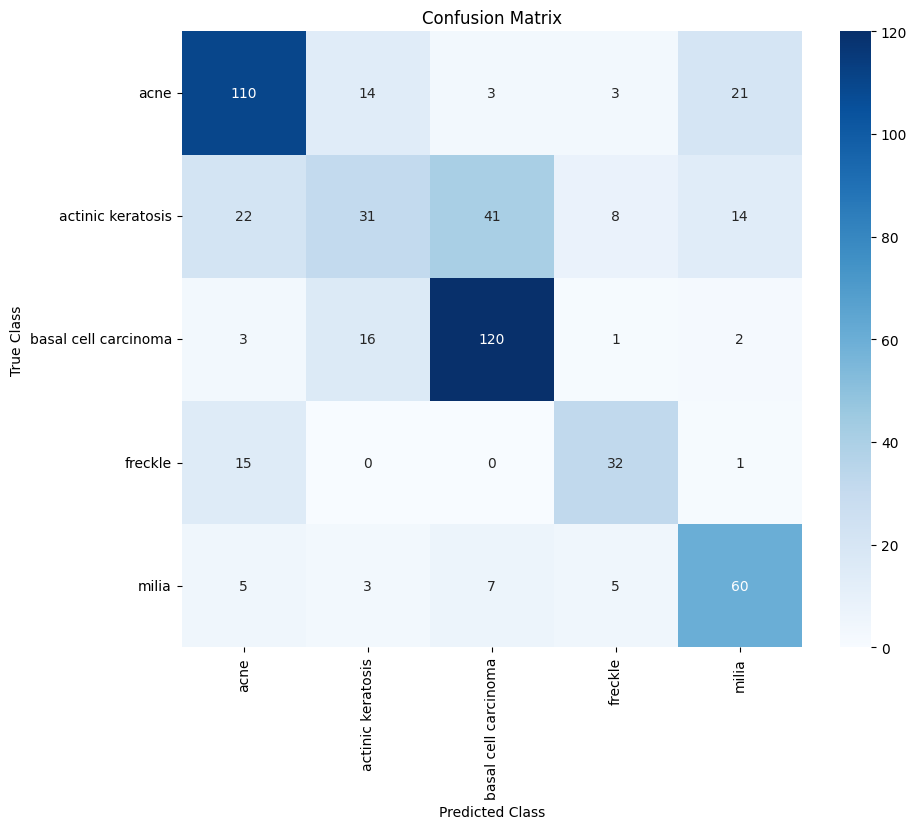

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

model = load_model('/content/drive/My Drive/Capstone/skinwisepro.h5')

images, true_labels = load_images_and_labels(test_images_path)

images = images / 255.0

predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# encoding to integers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
true_classes = to_categorical(true_labels_encoded)


cm = confusion_matrix(true_labels_encoded, predicted_classes)


class_labels = label_encoder.classes_

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


**Normalized Confusion Matrix**

17/17 [==============================] - 2s 33ms/step


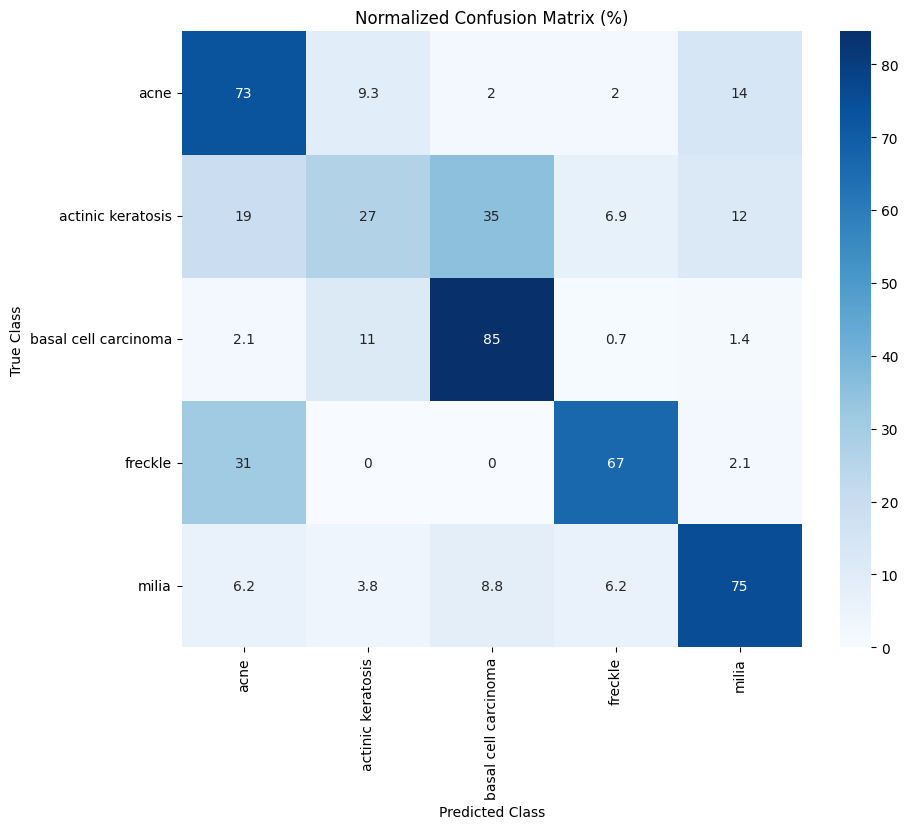

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


model = load_model('/content/drive/My Drive/Capstone/skinwisepro.h5')


images, true_labels = load_images_and_labels(test_images_path)


images = images / 255.0


predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# encoding to integers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
true_classes = to_categorical(true_labels_encoded)


cm = confusion_matrix(true_labels_encoded, predicted_classes)

# normalized to show percentages
cm_normalized = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_labels = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"va": "center", "ha": "center"})
plt.title('Normalized Confusion Matrix (%)')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


## Model Evaluation

We use the `evaluate` method to get the validation loss and validation accuracy for the model. This helps us to understand how well the model works with new data.  

- **Validation Loss**: Loss value for the model on validation data
- **Validation Accuracy**: Accuracy value for the model on validation data

In [ ]:
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


11/11 [==============================] - 2s 174ms/step - loss: 0.5432 - accuracy: 0.7500
Validation Loss: 0.5432058572769165
Validation Accuracy: 0.75


**Accuracy**

In [ ]:
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6574


## Plotting Training and Validation Metrics

We finally plot the training and validation performance per epoch.

- **Accuracy Plot**: This shows the proportion of right values predicted for the validation dataset.
- **Loss Plot**: This shows the error between the actual and the predicted values.

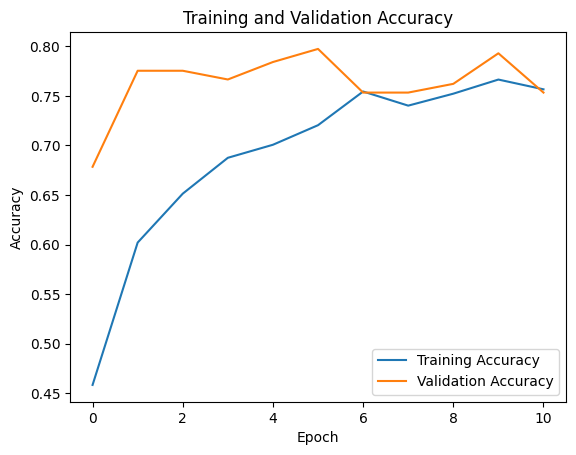

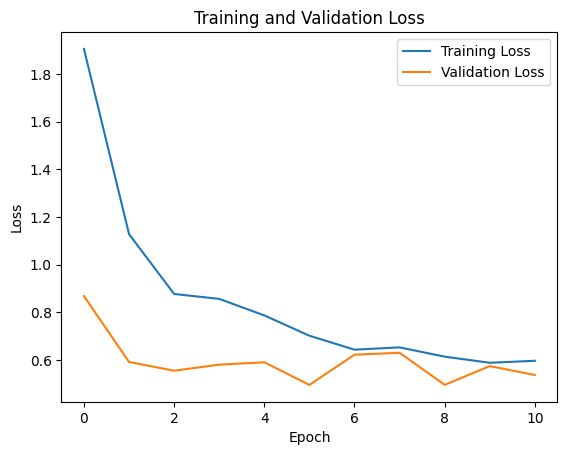

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
